In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from functools import reduce
import pandas as pd
from texttable import Texttable
from torchsummary import summary

### Load orginal data

In [2]:
import dataloader
train_data, train_label, test_data, test_label = dataloader.read_bci_data()

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


### Constrct EEGNet

In [3]:
class EEGNet(nn.Module):
    def __init__(self, activation):
        super(EEGNet, self).__init__()
        self.activation_func = activation
        
        self.layer_1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = (1, 51), stride = (1, 1), padding = (0, 25), bias = False),
            nn.BatchNorm2d(16, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True)    
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = (2, 1), stride = (1, 1), groups = 16, bias = False), 
            nn.BatchNorm2d(32, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
            self.activation_func(),
            nn.AvgPool2d(kernel_size=(1, 4), stride = (1, 4), padding = 0),
            nn.Dropout(0.25)
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size = (1, 15), stride = (1, 1), padding = (0, 7), bias = False), 
            nn.BatchNorm2d(32, eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
            self.activation_func(),
            nn.AvgPool2d(kernel_size=(1, 8), stride = (1, 8), padding = 0),
            nn.Dropout(0.5)
        )
        self.layer_4 = nn.Sequential(
                nn.Linear(in_features = 736, out_features = 2, bias = True)
        )
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        # flatten
#         view same as "reshape", "-1"means uncertain, "(行, 列)"
        x = x.reshape(-1, self.layer_4[0].in_features) 
        # Fully connected
        x = self.layer_4(x)
        return x 

In [4]:
model = EEGNet(nn.ReLU)
if torch.cuda.is_available():
    model.cuda()
summary(model, (1, 2, 750))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 2, 750]             816
       BatchNorm2d-2           [-1, 16, 2, 750]              32
            Conv2d-3           [-1, 32, 1, 750]              64
       BatchNorm2d-4           [-1, 32, 1, 750]              64
              ReLU-5           [-1, 32, 1, 750]               0
         AvgPool2d-6           [-1, 32, 1, 187]               0
           Dropout-7           [-1, 32, 1, 187]               0
            Conv2d-8           [-1, 32, 1, 187]          15,360
       BatchNorm2d-9           [-1, 32, 1, 187]              64
             ReLU-10           [-1, 32, 1, 187]               0
        AvgPool2d-11            [-1, 32, 1, 23]               0
          Dropout-12            [-1, 32, 1, 23]               0
           Linear-13                    [-1, 2]           1,474
Total params: 17,874
Trainable params: 

### DeepConv EEGNet

In [5]:
class DeepConvNet(nn.Module):
    def __init__(self, activation):
        super(DeepConvNet, self).__init__()
        self.deep = [25,50,100,200]
        self.activation_func = activation
        
        
        self.layer_0 = nn.Sequential(
            nn.Conv2d(1, self.deep[0], kernel_size = (1, 5), stride = (1, 1), padding = (0, 0), bias = True),
            nn.Conv2d(self.deep[0], self.deep[0], kernel_size = (2, 1), stride = (1, 1), padding = (0, 0), bias = True),
            nn.BatchNorm2d(self.deep[0], eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
            self.activation_func(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(0.2))
            
        for i in range(1, 4):
            setattr(self, 'layer_'+str(i),nn.Sequential(
                nn.Conv2d(self.deep[i-1], self.deep[i], kernel_size = (1, 5), stride = (1, 1), padding = (0, 0), bias = True),
                nn.BatchNorm2d(self.deep[i], eps = 1e-05, momentum = 0.1, affine = True, track_running_stats = True),
                self.activation_func(),
                nn.MaxPool2d(kernel_size=(1, 2)),
                nn.Dropout(0.5))
                )            
        self.layer_4 = nn.Sequential(
            nn.Linear(in_features = 8600, out_features = 2, bias = True)
        )
        
    def forward(self, x):
        x = self.layer_0(x)
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        # flatten
        x = x.reshape(-1, self.layer_4[0].in_features) #200*43=8600
        x = self.layer_4(x)
        return x

In [6]:
model = DeepConvNet(nn.ReLU)
if torch.cuda.is_available():
    model.cuda()
summary(model, (1, 2, 750))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 25, 2, 746]             150
            Conv2d-2           [-1, 25, 1, 746]           1,275
       BatchNorm2d-3           [-1, 25, 1, 746]              50
              ReLU-4           [-1, 25, 1, 746]               0
         MaxPool2d-5           [-1, 25, 1, 373]               0
           Dropout-6           [-1, 25, 1, 373]               0
            Conv2d-7           [-1, 50, 1, 369]           6,300
       BatchNorm2d-8           [-1, 50, 1, 369]             100
              ReLU-9           [-1, 50, 1, 369]               0
        MaxPool2d-10           [-1, 50, 1, 184]               0
          Dropout-11           [-1, 50, 1, 184]               0
           Conv2d-12          [-1, 100, 1, 180]          25,100
      BatchNorm2d-13          [-1, 100, 1, 180]             200
             ReLU-14          [-1, 100,

### Training / Testing func

In [7]:
def train(model, X, Y, batch_size, lr, epoch):
    
    model.train()
    Loss = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    
    X, Y = shuffle_data(X, Y)
    
    for i in range(len(X) // batch_size):
        start = i*batch_size
        end   = i*batch_size + batch_size

        x_train = Variable(torch.from_numpy(X[start:end]), requires_grad=True)
        y_train = Variable(torch.from_numpy(Y[start:end]), requires_grad=True)
        
        #所有最開始讀取數據時的tensor copy一份到device所指定的GPU上去，之後運算都在GPU上進行。
        x_train = x_train.to(device=device, dtype=torch.float)
        y_train = y_train.to(device=device, dtype=torch.long)
        
        optimizer.zero_grad()
        pred_y = model(x_train)
        loss = Loss(pred_y, y_train)
        loss.backward()
        optimizer.step()
    
    if (epoch%100 == 0):    
        print("Train Epoch : ", epoch, " Loss : ", loss.item())
    return model

def test(model, X, Y):
    model.eval()
    
    data = torch.from_numpy(X)
    data = data.to(device=device, dtype=torch.float)
    
    output = model(data)
    output = output.cpu()
    output = output.detach().numpy()
    pred_y = np.argmax(output, axis=1)
    acc = accuracy_score(Y, pred_y)
    return acc

In [8]:
def main_flow(NET_choose, nn_activation, Batch_size, Learning_rate, Epochs, train_data, train_label, test_data, test_label):
    print("Original")
    if NET_choose == 0:
        model_EGG = EEGNet(nn_activation)
        model_EGG.to(device)
        model_EGG.eval()
        acc_EGG_ELU = test(model_EGG, test_data, test_label)
        print("original accuracy：{}".format(acc_EGG_ELU))
        
        # store each eposhs' values
        acc_EGG_train = np.zeros(Epochs)
        acc_EGG_test  = np.zeros(Epochs)
        acc_EGG = 0
        
        for epoch in range(Epochs): 
            model_EGG = train(model_EGG, train_data, train_label, Batch_size, Learning_rate, epoch)
            acc_EGG_train[epoch] = test(model_EGG, train_data, train_label)
            acc_temp = test(model_EGG, test_data, test_label)
            acc_EGG_test[epoch] = acc_temp

            if (acc_temp > acc_EGG):
                acc_EGG = acc_temp
        print("\nAccur of EEGNet by using {}:{}".format(str(nn_activation), test(model_EGG, test_data, test_label)))
        return acc_EGG, acc_EGG_train, acc_EGG_test
    else :
        model_DeepConv = EEGNet(nn_activation)
        model_DeepConv.to(device)
        model_DeepConv.eval()
        acc_DeepConv_Ori = test(model_DeepConv, test_data, test_label)
        print("original accuracy：{}".format(acc_DeepConv_Ori))
        
        # store each eposhs' values
        acc_DeepConv_train = np.zeros(Epochs)
        acc_DeepConv_test  = np.zeros(Epochs)
        acc_DeepConv = 0
        
        for epoch in range(Epochs): 
            model_DeepConv = train(model_DeepConv, train_data, train_label, Batch_size, Learning_rate, epoch)
            acc_DeepConv_train[epoch] = test(model_DeepConv, train_data, train_label)
            acc_tmp = test(model_DeepConv, test_data, test_label)
            acc_DeepConv_test[epoch] = acc_tmp

            if (acc_tmp > acc_DeepConv):
#                 print (acc_temp)
                acc_DeepConv = acc_tmp
        print("\nAccur of DeepConvNet by using {}:{}".format(nn_activation, test(model_DeepConv, test_data, test_label)))
        return acc_DeepConv, acc_DeepConv_train, acc_DeepConv_test

In [9]:
def shuffle_data(X, Y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]
    return X, Y

In [10]:
def plt_result(NET_choose, ELU_train, ELU_test, ReLU_train, ReLU_test, LeakyReLU_train, LeakyReLU_test):
    plt.figure(figsize=(20,10))

    plt.plot(ELU_train)
    plt.plot(ELU_test)
    plt.plot(ReLU_train)
    plt.plot(ReLU_test)
    plt.plot(LeakyReLU_train)
    plt.plot(LeakyReLU_test)
    
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
        
    if NET_choose == 0:
        plt.title('EGGNet Active function comparison')

        plt.legend(['EGG with ELU_train', 'EGG with ELU_test',
            'EGG with ReLU_train', 'EGG with ReLU_test',
            'EGG with LeakyReLU_train', 'EGG with LeakyReLU_test'], bbox_to_anchor=(1.05, 1)
                  )
        plt.grid(True)
        plt.show()
        plt.savefig('For EEGNet.png')
    else:
        plt.title('DeepConv active function comparison')

        plt.legend(['DeepConv with ELU_train', 'DeepConv with ELU_test',
            'DeepConv with ReLU_train', 'DeepConv with ReLU_test',
            'DeepConv with LeakyReLU_train', 'DeepConv with LeakyReLU_test'], bbox_to_anchor=(1.05, 1)
                  )
        # bbox_to_anchor 放置在 Matplotlib 中的繪圖之外，放置在座標軸上的位置 (1.05, 1) 
        plt.grid(True)
        plt.show()
        plt.savefig('For DeepConvnet.png')

### Parameter define

In [11]:
Batch_size= 32   
Learning_rate = 0.001 
Epochs = 500
device = torch.device("cuda:0" )

#### For EEGNet

In [12]:
acc_EGG_ELU, acc_EGG_ELU_train, acc_EGG_ELU_test = main_flow(0, nn.ELU, Batch_size, Learning_rate, Epochs, 
                                                train_data, train_label, test_data, test_label)
acc_EGG_ReLU, acc_EGG_ReLU_train, acc_EGG_ReLU_test = main_flow(0, nn.ReLU, Batch_size, Learning_rate, Epochs, 
                                                  train_data, train_label, test_data, test_label)
acc_EGG_LeakyReLU, acc_EGG_LeakyReLU_train, acc_EGG_LeakyReLU_test = main_flow(0, nn.LeakyReLU, Batch_size, Learning_rate, Epochs, 
                                                            train_data, train_label, test_data, test_label)

Original
original accuracy：0.5231481481481481
Train Epoch :  0  Loss :  0.5892194509506226
Train Epoch :  100  Loss :  0.2919107973575592
Train Epoch :  200  Loss :  0.18616899847984314
Train Epoch :  300  Loss :  0.1452275514602661
Train Epoch :  400  Loss :  0.020089711993932724

Accur of EEGNet by using <class 'torch.nn.modules.activation.ELU'>:0.8231481481481482
Original
original accuracy：0.5092592592592593
Train Epoch :  0  Loss :  0.6323840618133545
Train Epoch :  100  Loss :  0.14333726465702057
Train Epoch :  200  Loss :  0.067038394510746
Train Epoch :  300  Loss :  0.28075164556503296
Train Epoch :  400  Loss :  0.03653592988848686

Accur of EEGNet by using <class 'torch.nn.modules.activation.ReLU'>:0.8657407407407407
Original
original accuracy：0.47685185185185186
Train Epoch :  0  Loss :  0.5500155687332153
Train Epoch :  100  Loss :  0.116921566426754
Train Epoch :  200  Loss :  0.060674749314785004
Train Epoch :  300  Loss :  0.01892627403140068
Train Epoch :  400  Loss : 

#### For DeepConvNet

In [13]:
acc_DeepConv_ELU, acc_DeepConv_ELU_train, acc_DeepConv_ELU_test = main_flow(1, nn.ELU, Batch_size, Learning_rate, Epochs, 
                                                          train_data, train_label, test_data, test_label)
acc_DeepConv_ReLU, acc_DeepConv_ReLU_train, acc_DeepConv_ReLU_test = main_flow(1, nn.ReLU, Batch_size, Learning_rate, Epochs, 
                                                            train_data, train_label, test_data, test_label)
acc_DeepConv_LeakyReLU, acc_DeepConv_LeakyReLU_train, acc_DeepConv_LeakyReLU_test = main_flow(1, nn.LeakyReLU, Batch_size, Learning_rate, Epochs, 
                                                                      train_data, train_label, test_data, test_label)

Original
original accuracy：0.5083333333333333
Train Epoch :  0  Loss :  0.4422089159488678
Train Epoch :  100  Loss :  0.23990121483802795
Train Epoch :  200  Loss :  0.04390671104192734
Train Epoch :  300  Loss :  0.030926020815968513
Train Epoch :  400  Loss :  0.11270870268344879

Accur of DeepConvNet by using <class 'torch.nn.modules.activation.ELU'>:0.8305555555555556
Original
original accuracy：0.5101851851851852
Train Epoch :  0  Loss :  0.6026825308799744
Train Epoch :  100  Loss :  0.06903871148824692
Train Epoch :  200  Loss :  0.1690894514322281
Train Epoch :  300  Loss :  0.06737914681434631
Train Epoch :  400  Loss :  0.12256559729576111

Accur of DeepConvNet by using <class 'torch.nn.modules.activation.ReLU'>:0.8583333333333333
Original
original accuracy：0.4824074074074074
Train Epoch :  0  Loss :  0.5642921328544617
Train Epoch :  100  Loss :  0.27787357568740845
Train Epoch :  200  Loss :  0.08565115183591843
Train Epoch :  300  Loss :  0.06730900704860687
Train Epoch : 

#### Plot Comparison Result

In [15]:
print("EEGNet v.s DeepConvNet")
tb=Texttable()
tb.set_cols_align(['l', 'c', 'c', 'c'])
tb.set_cols_dtype(['t', 'f', 'f', 'f'])
tb.add_rows([['Net', 'ReLU', 'Leaky ReLU', 'ELU'],
            ["EEGNet", acc_EGG_ReLU*100, acc_EGG_LeakyReLU*100, acc_EGG_ELU*100],
            ["DeepConvNet", acc_DeepConv_ReLU*100, acc_DeepConv_LeakyReLU*100, acc_DeepConv_ELU*100],
            ])
print(tb.draw())


# tb.add_rows(df.values, header=False)
# # tb.add_rows(['Net', 'ReLU', 'Leaky ReLU', 'ELU'])
# print(tb.draw())

EEGNet v.s DeepConvNet
+-------------+--------+------------+--------+
|     Net     |  ReLU  | Leaky ReLU |  ELU   |
+=============+========+============+========+
| EEGNet      | 87.500 |   89.074   | 83.981 |
+-------------+--------+------------+--------+
| DeepConvNet | 87.685 |   87.130   | 85.278 |
+-------------+--------+------------+--------+


#### Plot accur

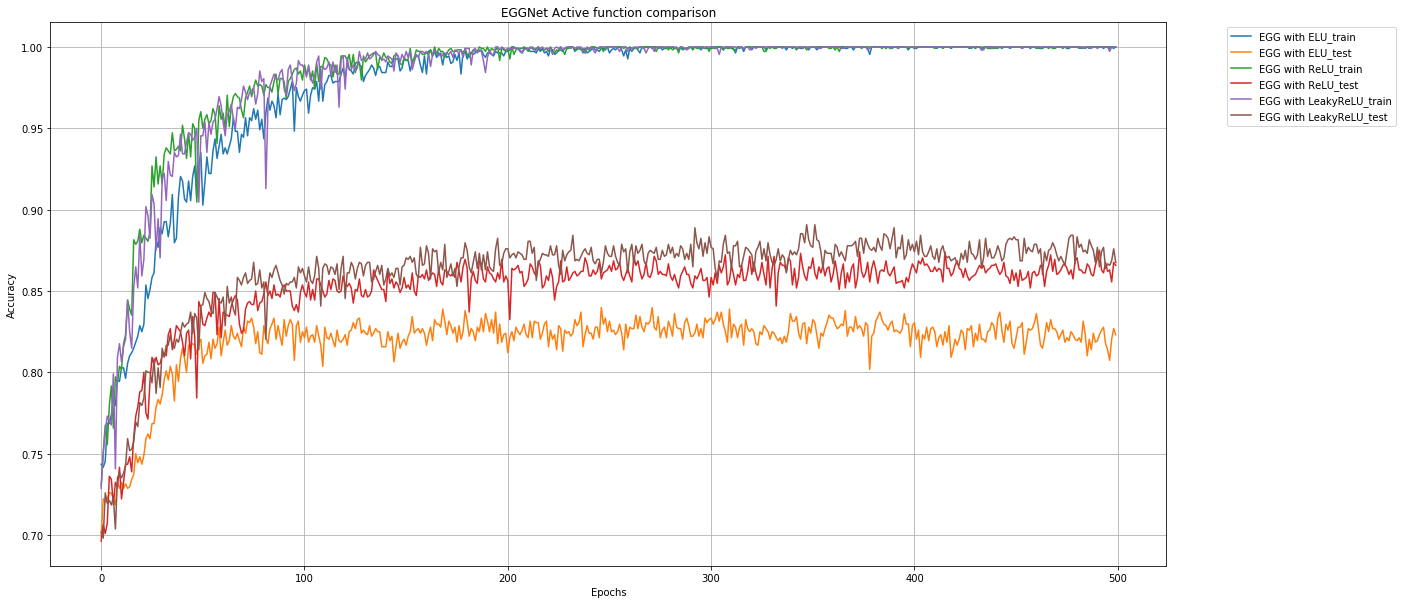

<Figure size 432x288 with 0 Axes>

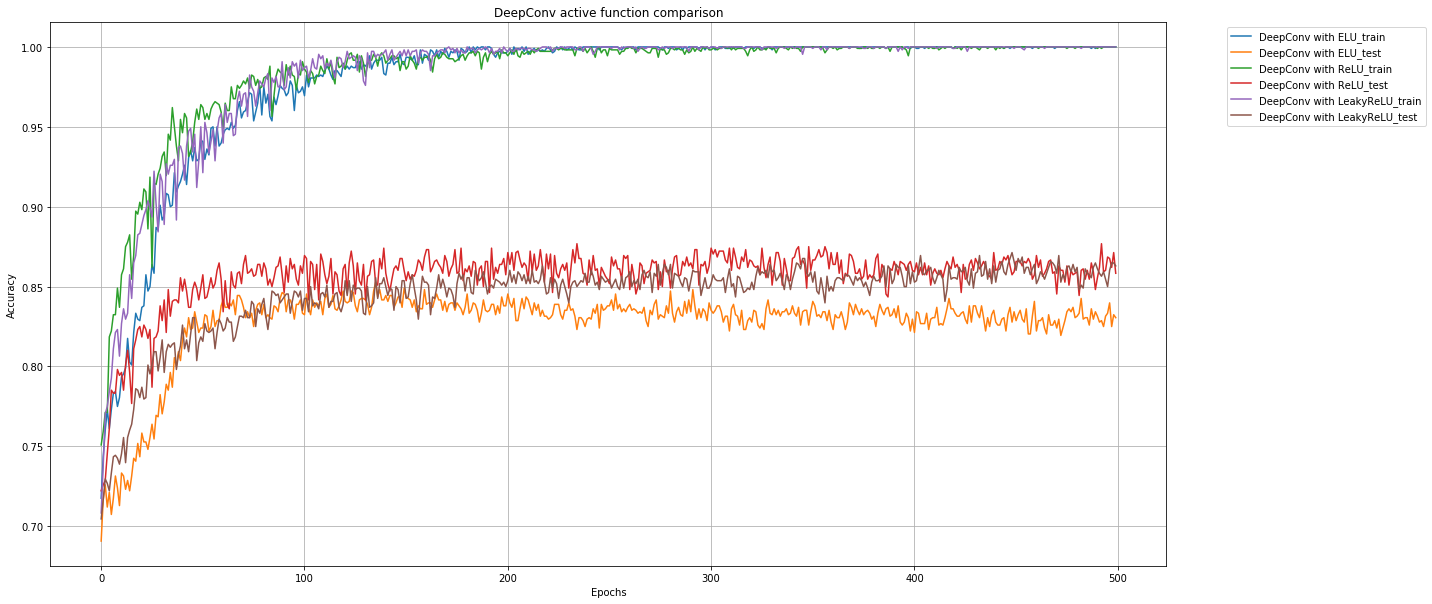

<Figure size 432x288 with 0 Axes>

In [16]:
plt_result(0, acc_EGG_ELU_train, acc_EGG_ELU_test, acc_EGG_ReLU_train, acc_EGG_ReLU_test,
          acc_EGG_LeakyReLU_train, acc_EGG_LeakyReLU_test)

plt_result(1, acc_DeepConv_ELU_train, acc_DeepConv_ELU_test, acc_DeepConv_ReLU_train, acc_DeepConv_ReLU_test,
          acc_DeepConv_LeakyReLU_train, acc_DeepConv_LeakyReLU_test)